<a href="https://colab.research.google.com/github/karenyxwang/Machine_Learning/blob/master/Project%204%20-%20Unsupervized%20ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6 (Due March 22, 2020)
In this homework we are working with a dataset of American universities, aggregated from government statistics. The dataset contains a large number of columns covering financial details, enrollment details, and so on. We will be using unsupervised dimensionality reduction to discover which features are highly related, and then using unsupervised clustering to discover which colleges are most similar.

# Initial Data Fetching and Setup

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lPoKPVXt9glGvBlxA-lwZDtmpyUsvIpL' -O colleges.csv


--2020-05-01 17:21:22--  https://docs.google.com/uc?export=download&id=1lPoKPVXt9glGvBlxA-lwZDtmpyUsvIpL
Resolving docs.google.com (docs.google.com)... 108.177.126.102, 108.177.126.138, 108.177.126.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/29tlv00lhqso4fbbt6e7tsl45nr5msq2/1588353675000/09640029349513786515/*/1lPoKPVXt9glGvBlxA-lwZDtmpyUsvIpL?e=download [following]
--2020-05-01 17:21:22--  https://doc-04-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/29tlv00lhqso4fbbt6e7tsl45nr5msq2/1588353675000/09640029349513786515/*/1lPoKPVXt9glGvBlxA-lwZDtmpyUsvIpL?e=download
Resolving doc-04-b0-docs.googleusercontent.com (doc-04-b0-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting to doc-04-b0-docs.googleusercontent.com (doc-04

In [ ]:
import pandas as pd
input_file = pd.read_csv("colleges.csv")
print(input_file.shape)

input_file_clean = {
    "Institution name": input_file["Institution name"]
}
for column in input_file.loc[:, input_file.columns[1:]]:
  clean_column = []
  original_column = input_file[column].replace("-", None)
  for x in original_column:
    try:
      clean_column.append(float(x))
    except:
      clean_column.append(None)
  input_file_clean[column] = clean_column
df = pd.DataFrame(input_file_clean)
df = df.dropna()


(3815, 77)



## Question 1 *(4 points)*

Manually choose four different subsets of features, each of which represents one concept about the colleges in this list. You do not need to use a large number of features, just enough to represent (by hand) the concept you are trying to approximate.

| Feature Set | Description                                                               |
|-------------|---------------------------------------------------------------------------|
| Size        | Features representing the size of a university.                |
| Selectivity | Features representing the difficulty of being admitted and/or graduating. |
| Diversity   | Features representing the breadth of  representation in the student body.              |
| **Score** | Features representing the scores of the students enrolled.         |

In [ ]:
# Create features that represent diversity
df["Percent of Asians"] = df["Total_Asian "]/df['All students total_Grand Total']
df["Percent of American Indian or Alaska Native"] = df["Total_American Indian or Alaska Native "]/df['All students total_Grand Total']
df["Percent of Black or African American"] = df["Total_Black or African American "]/df['All students total_Grand Total']
df["Percent of Hispanic or Latino"] = df["Total_Hispanic or Latino"]/df['All students total_Grand Total']
df["Percent of Pacific Islander"] = df["Total_Native Hawaiian or Other Pacific Islander "]/df['All students total_Grand Total']
df["Percent of White"] = df["Total_White "]/df['All students total_Grand Total']
df["Percent of two or more races"] = df["Total_Two or more races "]/df['All students total_Grand Total']
df["Percent of unknown race/ethnicity"] = df["Total_Race/ethnicity unknown "]/df['All students total_Grand Total']
df["Percent of Nonresident alien"] = df["Total_Nonresident alien "]/df['All students total_Grand Total']

# Select features for the features sets
size_features = ["All students total_Grand Total", "All full-time instructional staff"]
selectivity_features = ["Percent of Applicants Admitted", "Graduation rate (%)"]
diversity_features = ["Out-of-state - Percent", "Foreign countries - Percent",
                      "Foreign countries - Number", "Percent of Asians", "Percent of American Indian or Alaska Native",
                      "Percent of Black or African American", "Percent of Hispanic or Latino", "Percent of Pacific Islander",
                      "Percent of White", "Percent of two or more races", "Percent of unknown race/ethnicity", "Percent of Nonresident alien"]
score_features = ["Students submitting SAT scores - Percent", "SAT I Verbal - 25th Percentile", "SAT I Verbal - 75th Percentile", "SAT I Math - 25th Percentile", "SAT I Math - 75th Percentile" ]

feature_set = size_features + selectivity_features + diversity_features + score_features

# Extract all features
df_features = df.loc[:, feature_set]

## Task 2. *(14 points total)*

### Task 2.1 *(2 points)*
Normalized the features in the university dataset. Each feature in the resulting data frame should be normalized to a value between 0 and 1. Save this normalized representation to a variable named `df_norm`.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
df_norm = pd.DataFrame(scaler.fit_transform(df_features))
df_norm.columns = df_features.columns
print("After Scaling")
df_norm

After Scaling


,All students total_Grand Total,All full-time instructional staff,Percent of Applicants Admitted,Graduation rate (%),Out-of-state - Percent,Foreign countries - Percent,Foreign countries - Number,Percent of Asians,Percent of American Indian or Alaska Native,Percent of Black or African American,Percent of Hispanic or Latino,Percent of Pacific Islander,Percent of White,Percent of two or more races,Percent of unknown race/ethnicity,Percent of Nonresident alien,Students submitting SAT scores - Percent,SAT I Verbal - 25th Percentile,SAT I Verbal - 75th Percentile,SAT I Math - 25th Percentile,SAT I Math - 75th Percentile
0,0.210622,0.364450,0.921,0.583,0.154,0.013,0.021722,0.073330,0.002691,0.218720,0.030653,0.000275,0.589335,0.086728,0.013183,0.047849,0.01,0.495968,0.644444,0.408284,0.550
1,0.093511,0.051745,0.809,0.519,0.332,0.020,0.020946,0.046056,0.009963,0.097165,0.047042,0.000620,0.697206,0.057785,0.039339,0.046118,0.01,0.637097,0.822222,0.329389,0.700
2,0.042359,0.033850,0.977,0.300,0.409,0.011,0.007758,0.006141,0.001133,0.910265,0.009744,0.000456,0.038749,0.022895,0.011557,0.013143,0.24,0.395161,0.422222,0.270217,0.275
3,0.368863,0.221294,0.591,0.719,0.639,0.019,0.096199,0.014953,0.003621,0.105184,0.047695,0.001100,0.759781,0.074290,0.006252,0.031883,0.25,0.596774,0.688889,0.467456,0.600
4,0.016106,0.007158,0.591,0.283,0.024,0.019,0.096199,0.006595,0.002974,0.202261,0.023795,0.000000,0.753718,0.016392,0.003569,0.001190,0.25,0.596774,0.688889,0.467456,0.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,0.014770,0.001044,0.250,0.189,0.018,0.261,0.003879,0.011184,0.010376,0.049935,0.071984,0.004564,0.800259,0.055099,0.003243,0.026589,0.79,0.455645,0.422222,0.349112,0.300
3810,0.045251,0.001044,0.250,0.464,0.429,0.261,0.003879,0.006794,0.004243,0.351294,0.049427,0.001493,0.432329,0.068684,0.124735,0.001061,0.79,0.455645,0.422222,0.349112,0.300
3811,0.000221,0.000298,0.500,0.000,0.429,0.261,0.003879,0.307971,0.000000,0.250000,0.285714,0.035907,0.071429,0.000000,0.107143,0.000000,0.79,0.455645,0.422222,0.349112,0.300
3812,0.000577,0.000596,0.500,0.000,0.429,0.261,0.003879,0.000000,0.000000,0.015385,0.123077,0.000000,0.846154,0.035328,0.000000,0.000000,0.79,0.455645,0.422222,0.349112,0.300


### Task 2.2 Unsupervised Features *(6 points)*
Using principal component analysis on `df_norm`, generate a dimensionality-reduced representation of the university dataset. 

- Vary the number of components from 2 to 10. What percentage of variance is explained at each number of components?
- Set the number of components to 4. Which features load together with high weight in each component?



In [ ]:
from sklearn.decomposition import PCA
for i in range(2,11):
  pca = PCA(n_components=i)
  components = pca.fit_transform(df_norm)
  print(f"{round(sum(pca.explained_variance_ratio_*100), 2)}% of variance is explained at {i} components")

39.14% of variance is explained at 2 components
53.63% of variance is explained at 3 components
64.32% of variance is explained at 4 components
73.52% of variance is explained at 5 components
80.99% of variance is explained at 6 components
87.73% of variance is explained at 7 components
90.6% of variance is explained at 8 components
92.46% of variance is explained at 9 components
94.11% of variance is explained at 10 components


After setting the number of components to 4:

For component 1, features including Graduation rate (%), Out-of-state - Percent, Percent of Black or African American, Percent of Hispanic or Latino, Percent of White, Students submitting SAT scores - Percent, SAT I Math - 75th Percentile have high weight with an absolute value > 0.2

For component 2, features including Percent of Applicants Admitted, Graduation rate (%), Percent of Hispanic or Latino, Percent of White, Students submitting SAT scores - Percent, SAT I Verbal - 25th Percentile, SAT I Verbal - 75th Percentile, SAT I Math - 25th Percentile, SAT I Math - 75th Percentile have high weight with an absolute value more than 0.2.

For component 3, features including Percent of Black or African American, Percent of Hispanic or Latino, Percent of White, Students submitting SAT scores - Percenthave high weight with an absolute value more than 0.2.

For component 4, features including Graduation rate (%), Out-of-state - Percent, Percent of Black or African American, Percent of White, SAT I Verbal - 25th Percentile, SAT I Verbal - 75th Percentile, SAT I Math - 25th Percentile, SAT I Math - 75th Percentile have high weight.

In [ ]:
factors = pd.DataFrame({
    "Features":df_norm.columns,
    "Component 1": pca.components_[0],
    "Component 2": pca.components_[1],
    "Component 3": pca.components_[2],
    "Component 4": pca.components_[3]
})
factors

,Features,Component 1,Component 2,Component 3,Component 4
0,All students total_Grand Total,0.006576,0.046527,0.008005,-0.048708
1,All full-time instructional staff,0.035849,0.050954,0.006560,-0.005034
2,Percent of Applicants Admitted,-0.096376,-0.235658,-0.186672,-0.082033
3,Graduation rate (%),0.335587,0.304710,-0.027250,0.388070
4,Out-of-state - Percent,0.349139,0.164670,0.060439,0.636179
5,Foreign countries - Percent,0.001135,0.060402,0.007995,0.017511
6,Foreign countries - Number,0.015496,0.071128,0.014137,-0.020437
7,Percent of Asians,-0.017145,0.072075,0.023046,-0.001911
8,Percent of American Indian or Alaska Native,-0.019018,-0.016773,0.026743,-0.008551
9,Percent of Black or African American,-0.226738,-0.052265,0.206825,0.333882


### Task 2.3. Unsupervised Clusters (6 points) 
Tune a K-means cluster model on this dataset, using the features from `df_norm`. In particular, tune the number of clusters *K* to a level that, in your best judgment, produces representative clusters and appropriate complexity.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, mutual_info_score

sils = []
for k in range(2,21):

    # Learn Clusters
    learner = KMeans(n_clusters=k, random_state = 123)
    clusters = learner.fit(df_norm)
    df_norm["cluster"] = clusters.labels_
    silhouette = silhouette_score(df_norm, df_norm["cluster"])
    sils.append(silhouette)
    print(f"K={k}, silhouette={silhouette:.3f}")

K=2, silhouette=0.384
K=3, silhouette=0.402
K=4, silhouette=0.420
K=5, silhouette=0.448
K=6, silhouette=0.459
K=7, silhouette=0.466
K=8, silhouette=0.468
K=9, silhouette=0.486
K=10, silhouette=0.471
K=11, silhouette=0.500
K=12, silhouette=0.489
K=13, silhouette=0.503
K=14, silhouette=0.508
K=15, silhouette=0.491
K=16, silhouette=0.528
K=17, silhouette=0.506
K=18, silhouette=0.528
K=19, silhouette=0.534
K=20, silhouette=0.518


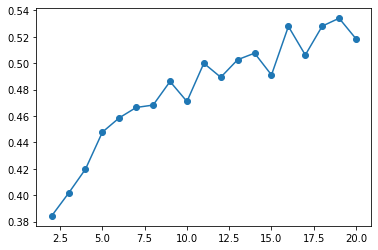

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(2,21), sils, marker = "o")

## Question 3 *(6 points)*

   - What number of clusters did you choose, and what was your evaluation process for choosing that value?
   - Do the sets of features you chose manually align with the principal components and/or clusters you discovered?
   - What additional features, not present in this data, would be useful to group together similar universities using unsupervised learning?



I chose 13 clusters based on the observation of the changes in silhouette score as the number of clusters increases. A silhouette score closer to 1 means that the clusters are cleanly assigned. The plot shows that the silhouette score improves quickly form 0.324 to 0.510 as the number of clusters increases from 2 to 13. However, it didn't change that much (only 0.01) as the number of clusters increases from 13 to 20. Therefore I decided that 13 clusters should be good enough to produce representative clusters with appropriate complexity.

The sets of features I chose manually did't align with the principal components I discovered. Especially, the "size" feature set had very little weight in PCA across all four components. A portion of the features I chose manually for other three feature sets, including diversity, selectivity, and score, have high weights in each of the four components. For example, Graduation rate (%) had high weight in three of the four components, representing the selectivity feature set. However, since PCA reduces high number of correlated features to a lower number of uncorrelated features, some of the features I manually chose had lower weight in PCA. For example, for the diversity feature set, three features, including Out-of-state - Percent, Percent of Black or African American, Percent of White, are the most representative and have the higher weight. The weights of the rest of the features in diversity feature set are reduced in PCA.


Financial features, such as the funding of the universities from various sources as well as the income of the universities, would be useful. Also, the performance of students after graduation, including their employment rate and average income level, would also be useful when evaluating and grouping similar universities. Finally, the geographical location of the universities should also be useful.